In [101]:
import numpy as np
import pandas as pd
import pyreadstat
from scipy.stats.mstats import winsorize
import seaborn as sns
import matplotlib.pyplot as plt

In [106]:
file_path = 'dataset2.sav'
df, meta = pyreadstat.read_sav(file_path)
df.rename(columns = {'yj13.2':'ЗП',
                     'yj72.18a':'Образование',
                     'yj6.2':'Рабочая неделя',
                     'yj10.2':'Премия',
                     'yj21b':'Отпуск',
                     'yj1.1.1': 'Удовлетворенность'},
                inplace = True)

df.describe()

,Отпуск,Рабочая неделя,Премия,ЗП,Удовлетворенность,Образование
count,12120.000000,12120.000000,12120.000000,12120.000000,12120.000000,12120.000000
mean,30.216254,42.734076,9291.592288,30096.143401,2.291337,2.030858
std,11.353607,9.596307,11207.974416,19347.575642,1.033968,0.780807
min,2.000000,3.000000,103.086563,0.000000,1.000000,1.000000
25%,23.000000,38.000000,3110.501834,17251.159839,2.000000,1.000000
50%,29.000000,41.000000,5896.856629,25157.061482,2.000000,2.000000
75%,37.000000,48.000000,11187.145533,37928.344140,3.000000,3.000000
max,150.000000,168.000000,296831.006422,259482.720979,5.000000,4.000000


In [ ]:
def detect_deviation(data: pd.DataFrame, method):
    data = data.copy()
    if method == 'iqr':
        columns = data.columns
        for column in columns:
            actual = data[column]
            Q1 = actual.quantile(0.25)
            Q3 = actual.quantile(0.75)
            IQR = Q3 - Q1

            mx = Q3 + 1.5 * IQR
            mn = Q1 - 1.5 * IQR

            actual_flags = pd.Series(
                [False if mn <= value <= mx else True for value in actual]
            )
            data[f'{column}_deviation'] = actual_flags


    elif method == 'zscore':
        columns = data.columns
        for column in columns:
            actual = data[column]
            zscore = (actual - actual.mean()) / actual.std()

            actual_flags = pd.Series(
                [False if -3 <= value <= 3 else True for value in zscore]
            )
            data[f'{column}_deviation'] = actual_flags
    
    return data

data_iqr = detect_deviation(df, 'iqr')
data_zscore = detect_deviation(df, 'zscore')


-9004.463713402203 23302.11108016141


In [ ]:
def winsorizing(data: pd.DataFrame, interval: int = 5):
    cleaned_data = data.copy()
    columns = data.columns
    for column in columns:
        cleaned_data[column] = winsorize(cleaned_data[column], limits=[interval / 100, interval / 100])  # Winsorize 5% с каждой стороны
    return cleaned_data


def handle_deviations(data: pd.DataFrame, strategy):
    cleaned_data = data.copy()
    if strategy == 'remove':
        columns = [column for column in cleaned_data.columns if 'deviation' in column]
        for column in columns:
            cleaned_data = cleaned_data[cleaned_data[column] == False]

    elif strategy == 'replace_mean': # Замена на среднее  
        columns = [column for column in data.columns if 'deviation' not in column]
        for column in columns:
            cl_f = f'{column}_deviation'
            mean_value = cleaned_data[cleaned_data[cl_f] == False][column].mean()
            cleaned_data.loc[cleaned_data[cl_f] == True, column] = mean_value

    elif strategy == 'replace_median': # Замена на медиану 
        columns = [column for column in data.columns if 'deviation' not in column]
        for column in columns:
            cl_f = f'{column}_deviation'
            median_value = cleaned_data[cleaned_data[cl_f] == False][column].median()
            cleaned_data.loc[cleaned_data[cl_f] == True, column] = median_value
        
    return cleaned_data

# cleaned_data_iqr = handle_deviations(data_iqr, strategy='remove')
cleaned_data_zscore = handle_deviations(data_zscore, strategy='replace_median')
cleaned_data = winsorizing(df)
cleaned_data_zscore.describe()
# print(cleaned_data.head())

,Отпуск,Рабочая неделя,Премия,ЗП,Удовлетворенность,Образование
count,12120.000000,12120.000000,12120.000000,12120.000000,12120.000000,12120.000000
mean,30.084818,42.048515,8231.313650,28591.939582,2.291337,2.030858
std,11.063197,7.362635,7487.089979,15554.059835,1.033968,0.780807
min,2.000000,14.000000,103.086563,0.000000,1.000000,1.000000
25%,23.000000,39.000000,3110.501834,17251.159839,2.000000,1.000000
50%,29.000000,41.000000,5753.377761,25000.000000,2.000000,2.000000
75%,37.000000,47.000000,10633.271248,36264.487979,3.000000,3.000000
max,64.000000,70.000000,42902.455516,88118.566273,5.000000,4.000000


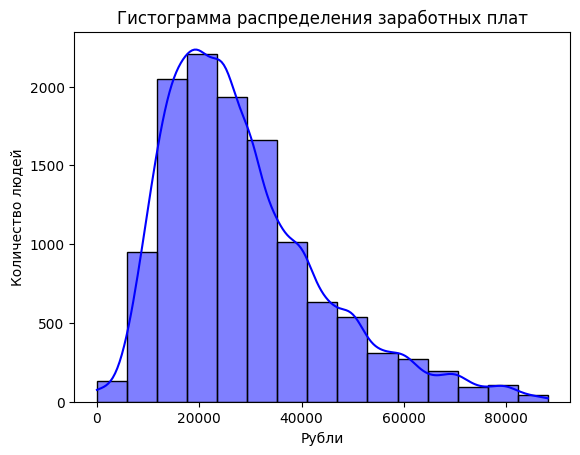

In [102]:
data = cleaned_data_zscore['ЗП']
sns.histplot(data, bins=15, kde=True, color='blue')
plt.xlabel("Рубли")
plt.ylabel("Количество людей")
plt.title("Гистограмма распределения заработных плат")
plt.show()

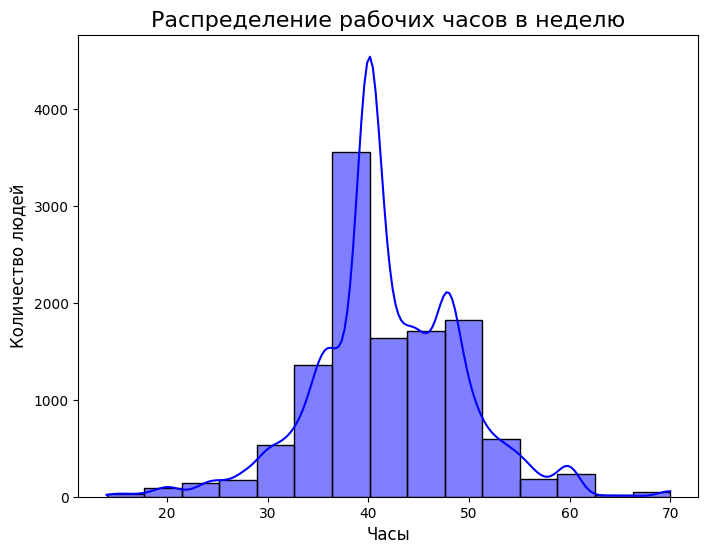

In [103]:
data = cleaned_data_zscore['Рабочая неделя']
plt.figure(figsize=(8, 6))
sns.histplot(data, bins=15, kde=True, color='blue')

# Подписи
plt.title('Распределение рабочих часов в неделю', fontsize=16)
plt.xlabel('Часы', fontsize=12)
plt.ylabel('Количество людей', fontsize=12)
plt.show()

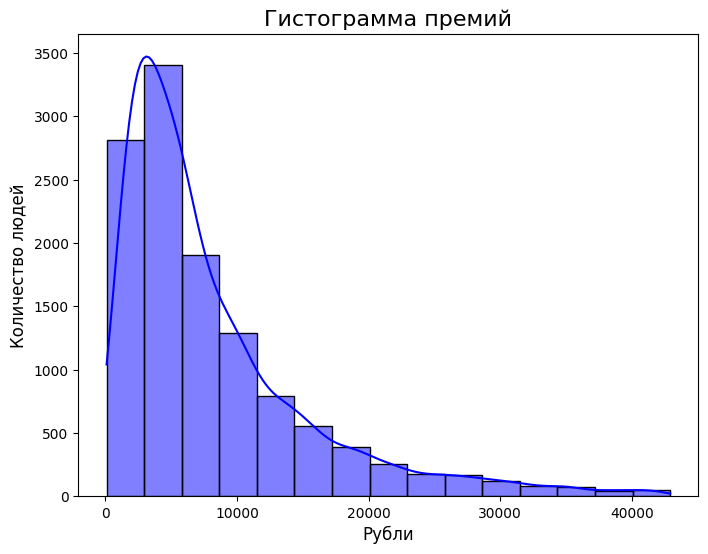

In [104]:
data = cleaned_data_zscore['Премия']
plt.figure(figsize=(8, 6))
sns.histplot(data, bins=15, kde=True, color='blue')

# Подписи
plt.title('Гистограмма премий', fontsize=16)
plt.xlabel('Рубли', fontsize=12)
plt.ylabel('Количество людей', fontsize=12)
plt.show()

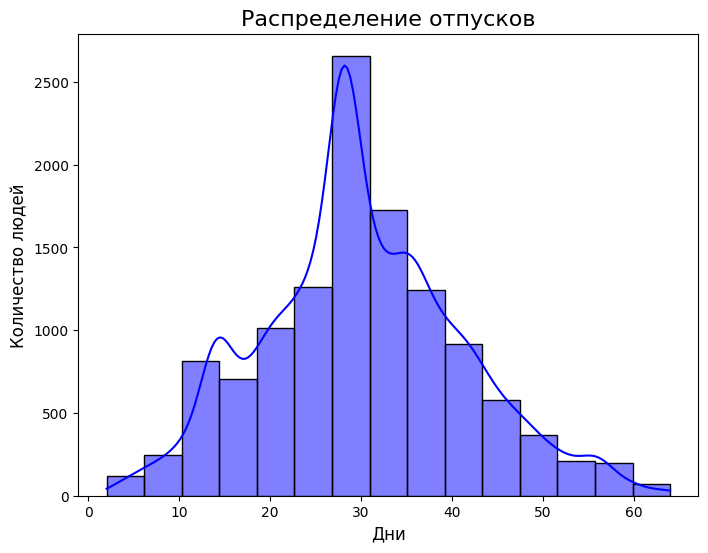

In [105]:
data = cleaned_data_zscore['Отпуск']
plt.figure(figsize=(8, 6))
sns.histplot(data, bins=15, kde=True, color='blue')

# Подписи
plt.title('Распределение отпусков', fontsize=16)
plt.xlabel('Дни', fontsize=12)
plt.ylabel('Количество людей', fontsize=12)
plt.show()